# Progressive read size evaluation

### This section is using the big 15GB data file as a source. See below for new configuration.
We know we can do 10k reads so let's take progressively larger number of reads to show a progression of processing time.

In [9]:
from pyspark import SparkContext

In [10]:
import subprocess
import os

In [11]:
import eulercuda as ec

In [12]:
import pycuda.driver
import pycuda.autoinit

In [13]:
from tqdm import *

## Reading Data
In this case I'm going to read a local data file into a list then ranomize the list and take slices. Then use Spark to parallelize the slice to turn it into an RDD.

In [6]:
datafile = '/home/ubuntu/genome/Ecoli-RR359304-2.fastq'

In [7]:
def read_fastq(filename, total):
    """
    Read fastq formatted <filename> and return a list of reads
    """
    result = []
    infile = open(filename, "r")
    for i,line in tqdm(enumerate(infile), desc='parsing', total=total):
        if i % 4 == 1:
            result.append(line.rstrip())
    return result

In [8]:
lines = 389607888 # hardcoded b/c this won't change for this file.

In [9]:
raw_data = read_fastq('/home/ubuntu/genome/Ecoli-RR359304-2.fastq',lines)

parsing: 100%|██████████| 389607888/389607888 [05:43<00:00, 1135714.40it/s]


In [ ]:
raw_data[:5]

In [10]:
from random import choice, shuffle

In [ ]:
#shuffle(raw_data) # maybe shuffle isn't needed with choice...

In [11]:
def build_dataset(num_reads, raw_data):
    data = []
    seq = ''
    for i in range(num_reads):
        seq = choice(raw_data)
        while 'N' in seq:
            seq = choice(raw_data)
        data.append(choice(raw_data))
    return data

### 10K reads

In [12]:
data = build_dataset(10000, raw_data)

In [18]:
len(data[0])

50

In [26]:
rdd_data = sc.parallelize(data,5)

In [27]:
dataLength = len(data[0])
dataCount = rdd_data.count() // rdd_data.getNumPartitions()

In [28]:
dataCount

2000

In [12]:
k = 17
lmerLength = 18

In [14]:
def hail_mary(path, data):
    import eulercuda.eulercuda as ec
    subprocess.call(["hdfs", "dfs", "-rm", "-r", "-f", '/genome/' + path])
    hail_mary = data.mapPartitions(lambda x: ec.assemble2(k, buffer=x, readLength = dataLength,readCount=dataCount)) \
        .saveAsTextFile('hdfs://172.31.26.32/genome/' + path)

In [32]:
%timeit hail_mary('ec10k_output',rdd_data)

1 loop, best of 3: 22.9 s per loop


## 15K reads

In [33]:
data = build_dataset(15000,raw_data)

In [39]:
rdd_data = sc.parallelize(data, 7)

In [40]:
dataLength = len(data[0])
dataCount = rdd_data.count() // rdd_data.getNumPartitions()

In [41]:
dataCount

2142

In [37]:
k = 17
lmerLength = 18

In [42]:
%timeit hail_mary('ec15k_output',rdd_data)

1 loop, best of 3: 32 s per loop


## 20K reads

In [43]:
data = build_dataset(20000,raw_data)

In [44]:
rdd_data = sc.parallelize(data, 10)

In [45]:
dataLength = len(data[0])
dataCount = rdd_data.count() // rdd_data.getNumPartitions()

In [46]:
dataCount

2000

In [47]:
%timeit hail_mary('ec20k_output',rdd_data)

1 loop, best of 3: 37.2 s per loop


## 25K reads

In [48]:
data = build_dataset(25000,raw_data)

In [49]:
rdd_data = sc.parallelize(data, 12)

In [50]:
dataLength = len(data[0])
dataCount = rdd_data.count() // rdd_data.getNumPartitions()
dataCount

2083

In [51]:
%timeit hail_mary('ec25k_output',rdd_data)

1 loop, best of 3: 46.1 s per loop


## 30K reads

In [54]:
data_size = 30000

In [52]:
data = build_dataset(30000,raw_data)

In [55]:
rdd_data = sc.parallelize(data, (data_size // 2000))

In [56]:
dataLength = len(data[0])
dataCount = rdd_data.count() // rdd_data.getNumPartitions()
dataCount

2000

In [57]:
%timeit hail_mary('ec30k_output',rdd_data)

1 loop, best of 3: 57 s per loop


## 35K reads

In [58]:
data_size = 35000

In [59]:
data = build_dataset(data_size, raw_data)

In [60]:
rdd_data = sc.parallelize(data, (data_size // 2000))

In [61]:
dataLength = len(data[0])
dataCount = rdd_data.count() // rdd_data.getNumPartitions()
dataCount

2058

In [62]:
%timeit hail_mary('ec35k_output',rdd_data)

1 loop, best of 3: 1min 5s per loop


## 40K reads

In [14]:
data_size = 35000

In [15]:
data = build_dataset(data_size, raw_data)

In [16]:
rdd_data = sc.parallelize(data, (data_size // 2000))

In [17]:
dataLength = len(data[0])
dataCount = rdd_data.count() // rdd_data.getNumPartitions()
dataCount

2058

In [6]:
#%timeit hail_mary('ec35k_output',rdd_data)

## This is working well enough maybe we should automate?

### This didn't work.  New method below

In [1]:
# data_size = 40000
# is_error = False
# times = {}
# while True:
#     print('Starting ' + str(data_size) + '\n')
#     data = build_dataset(data_size, raw_data)
#     rdd_data = sc.parallelize(data, (data_size // 2000))
#     dataLength = len(data[0])
#     dataCount = rdd_data.count() // rdd_data.getNumPartitions()
#     print('dataCount = ' + str(dataCount))
#     data_time = %timeit -o hail_mary('ec'+str(data_size)[:2]+'k_output',rdd_data)
#     print(str(data_size), data_time.best)
#     times[data_size]= data_time 
#     data_size += 5000
# #     except:
#         is_error = True
#         print('Fatal error on ' + str(data_size))

# New method using "cleaned" ecoli data file

In [2]:
datafile = '/home/ubuntu/genome/ecoli-clean.txt'

In [8]:
timing_data = {}
increment = 5000
read_size = 6000
dataset = []

In [15]:
def make_dataset(read_size):
    dataset = []
    with open (datafile, 'r') as infile:
        for i in range(read_size):
            line = infile.readline().rstrip()
            if 'N' not in line:
                dataset.append(line)
    return dataset

In [19]:
k = 17
lmerLength = 18
while True:
    print('Starting ' + str(read_size) + '\n')
    dataset = make_dataset(read_size)
    dataLength = len(dataset[0])
    rdd_data = sc.parallelize(dataset, (read_size // 2000))
    dataCount = rdd_data.count() // rdd_data.getNumPartitions()
    time = %timeit -o hail_mary('ec'+str(read_size)[:2]+'k_output',rdd_data)
    timing_data[read_size] = time
    print(read_size,time.best)
    print()
    read_size += increment

Starting 6000

1 loop, best of 3: 15.8 s per loop
6000 15.802363910999702

Starting 11000

1 loop, best of 3: 24.8 s per loop
11000 24.786940824999874

Starting 16000

1 loop, best of 3: 30.2 s per loop
16000 30.179472974999953

Starting 21000

1 loop, best of 3: 39 s per loop
21000 39.00074063300053

Starting 26000

1 loop, best of 3: 48.9 s per loop
26000 48.947659196999666

Starting 31000

1 loop, best of 3: 58.3 s per loop
31000 58.28229980500055

Starting 36000

1 loop, best of 3: 1min 6s per loop
36000 66.2625498310008

Starting 41000

1 loop, best of 3: 1min 13s per loop
41000 73.65370573700056

Starting 46000

1 loop, best of 3: 1min 22s per loop
46000 82.31506324700058

Starting 51000

1 loop, best of 3: 1min 31s per loop
51000 91.65724655099984

Starting 56000



Py4JJavaError: An error occurred while calling o535.saveAsTextFile.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 59.0 failed 4 times, most recent failure: Lost task 0.3 in stage 59.0 (TID 767, ip-172-31-26-33.ec2.internal): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/hadoop/yarn/local/usercache/ubuntu/appcache/application_1479440346004_0002/container_e57_1479440346004_0002_01_000003/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/hadoop/yarn/local/usercache/ubuntu/appcache/application_1479440346004_0002/container_e57_1479440346004_0002_01_000003/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/2.4.2.0-258/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/2.4.2.0-258/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "<ipython-input-14-ac16707478c8>", line 4, in <lambda>
  File "./eulercuda.zip/eulercuda/eulercuda.py", line 500, in assemble2
    lmerLength, evList, eeList, levEdgeList, entEdgeList, readCount)
  File "./eulercuda.zip/eulercuda/eulercuda.py", line 262, in constructDebruijnGraph
    d_TK, d_TV, d_bucketSize, bucketCount, d_ev, d_levEdge, d_entEdge, d_ee, readLength)
  File "./eulercuda.zip/eulercuda/pydebruijn.py", line 618, in construct_debruijn_graph_device
    bucketCount, d_l, d_e, d_ee, d_lstart, d_estart, valid_bitmask)
  File "./eulercuda.zip/eulercuda/pydebruijn.py", line 506, in setup_edges_device
    np_d_l.get(d_l)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/pycuda/gpuarray.py", line 272, in get
    _memcpy_discontig(ary, self, async=async, stream=stream)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/pycuda/gpuarray.py", line 1191, in _memcpy_discontig
    drv.memcpy_dtoh(dst, src.gpudata)
pycuda._driver.LogicError: cuMemcpyDtoH failed: an illegal memory access was encountered

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1431)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1419)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1418)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:47)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1418)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:799)
	at scala.Option.foreach(Option.scala:236)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:799)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1640)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1588)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:620)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1855)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1945)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply$mcV$sp(PairRDDFunctions.scala:1213)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopDataset$1.apply(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:323)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1156)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply$mcV$sp(PairRDDFunctions.scala:1060)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$4.apply(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:323)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1026)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply$mcV$sp(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$saveAsHadoopFile$1.apply(PairRDDFunctions.scala:952)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:323)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:951)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply$mcV$sp(RDD.scala:1464)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1443)
	at org.apache.spark.rdd.RDD$$anonfun$saveAsTextFile$1.apply(RDD.scala:1443)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:150)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:111)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:323)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1443)
	at org.apache.spark.api.java.JavaRDDLike$class.saveAsTextFile(JavaRDDLike.scala:507)
	at org.apache.spark.api.java.AbstractJavaRDDLike.saveAsTextFile(JavaRDDLike.scala:46)
	at sun.reflect.GeneratedMethodAccessor43.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:381)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:209)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/hadoop/yarn/local/usercache/ubuntu/appcache/application_1479440346004_0002/container_e57_1479440346004_0002_01_000003/pyspark.zip/pyspark/worker.py", line 111, in main
    process()
  File "/hadoop/yarn/local/usercache/ubuntu/appcache/application_1479440346004_0002/container_e57_1479440346004_0002_01_000003/pyspark.zip/pyspark/worker.py", line 106, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/hdp/2.4.2.0-258/spark/python/pyspark/rdd.py", line 2346, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/usr/hdp/2.4.2.0-258/spark/python/pyspark/rdd.py", line 317, in func
    return f(iterator)
  File "<ipython-input-14-ac16707478c8>", line 4, in <lambda>
  File "./eulercuda.zip/eulercuda/eulercuda.py", line 500, in assemble2
    lmerLength, evList, eeList, levEdgeList, entEdgeList, readCount)
  File "./eulercuda.zip/eulercuda/eulercuda.py", line 262, in constructDebruijnGraph
    d_TK, d_TV, d_bucketSize, bucketCount, d_ev, d_levEdge, d_entEdge, d_ee, readLength)
  File "./eulercuda.zip/eulercuda/pydebruijn.py", line 618, in construct_debruijn_graph_device
    bucketCount, d_l, d_e, d_ee, d_lstart, d_estart, valid_bitmask)
  File "./eulercuda.zip/eulercuda/pydebruijn.py", line 506, in setup_edges_device
    np_d_l.get(d_l)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/pycuda/gpuarray.py", line 272, in get
    _memcpy_discontig(ary, self, async=async, stream=stream)
  File "/home/ubuntu/anaconda3/lib/python3.5/site-packages/pycuda/gpuarray.py", line 1191, in _memcpy_discontig
    drv.memcpy_dtoh(dst, src.gpudata)
pycuda._driver.LogicError: cuMemcpyDtoH failed: an illegal memory access was encountered

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:207)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:125)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:38)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:313)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:277)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:66)
	at org.apache.spark.scheduler.Task.run(Task.scala:89)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:214)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [21]:
dir(timing_data[6000])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_precision',
 '_repr_pretty_',
 'all_runs',
 'best',
 'compile_time',
 'loops',
 'repeat',
 'worst']

In [22]:
timing_data[6000].all_runs

[15.925483254999563, 15.802363910999702, 15.934597277000648]

In [24]:
from matplotlib import pyplot
%matplotlib inline

In [31]:
x = [v.best for v in timing_data.values()]
y = [k//1000 for k in timing_data.keys()]

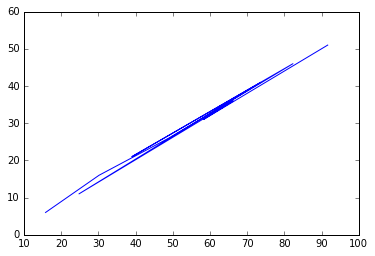

In [32]:
pyplot.plot(x, y)
# timing_data.keys()